In [68]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import datetime

import sys
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *

In [69]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


`%matplotlib` prevents importing * from pylab and numpy


In [70]:
#
# random time series
#
date = pd.date_range(start='2015-01', end='2015-05', freq='D')
price = np.random.randint(-100, 100, size=len(date))
df = pd.DataFrame(price, index=date, columns=['close'])
df = df.cumsum()

In [71]:
#
# Real ticker data
#
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime.now()

price_data = data.DataReader('SPY', 'yahoo', start, end)
adjclose_series = price_data['Adj Close']
adjclose_series.name = 'close'

df = pd.DataFrame(adjclose_series)

In [374]:
strategyname = 'strategy_180113'
d, info = matlab.loaddata('../../mat/'+strategyname+'.mat')

df = pd.DataFrame()
df['close'] = d.exo

## Renko calculation

## High/Low of renko bricks is only needed for visual representation

In [410]:
box_size = 500

box_start = 0
box_start_idx = None

box_end = 0
box_quantity = 0

temp_l = []

# Simple renko algorihtm


# 
for i in range(len(df)):
    if box_start == 0:
        box_start = df.close[i]

    else:
        box_start = box_start
        price_move = df.close[i] - box_start
        
        # First of all we need to set box size. 
        # Then calculate price movement. 
        # If price movement is more or equal than box size - renko bar(or bars) will be added
        
        if np.abs(price_move) >= box_size:
            
            # After we calculate box_quantity(price move divided by box size)
            # This number defines how much renko bars will be registred
            box_quantity = np.int32(np.floor(np.abs(price_move / box_size)))
            box_index = df.close.index[i]

            for b in range(int(box_quantity)):
            # Let say, index is 2015-01-01, box_start = 100, box_quantity = 3, box size = 10, price move > 0
            # So renko bar 1 will have next parameters - 
            # 1)index 2015-01-01
            # 2)open = 100
            # 3)close = 110(box_start + box_size)
            # 4)type = up
            
            # Next renko bar will have next parameters -
            # 1)index 2015-01-01
            # 2)open = 110(previous renko bar close)
            # 3)close = 120(open + box_size)
            # 4)type = up
            
            # And so on..
            
            # After all we adding renko bars dict to list and convert it to DF
            
                if price_move > 0:
                    if box_end == 0:
                        d = {'date': box_index, 'open': box_start, 'close': box_start + box_size, 'type': 'up'}
                        box_end = d['close']
                        temp_l.append(d)
                        
                    else:
                        d = {'date': box_index, 'open': box_end, 'close': box_end + box_size,
                            'type': 'up'}
                        
                        box_end = d['close']
                        temp_l.append(d)

                if price_move < 0:
                    if box_end == 0:
                        d = {'date': box_index, 'open': box_start, 'close': box_start - box_size, 'type': 'down'}
                        box_end = d['close']
                        temp_l.append(d)
                        
                    else:           
                        d = {'date': box_index, 'open': box_end, 'close': box_end - box_size, 
                             'type': 'down'}
                        
                        box_end = d['close']
                        temp_l.append(d)
                        
            box_start = df.close[i]
            
renko_df = pd.DataFrame(temp_l)

del temp_l

high_l = []
low_l = []
for i in range(len(renko_df)):
    if renko_df.close[i] > renko_df.open[i]:
        high_l.append(renko_df.close[i])
        low_l.append(renko_df.open[i])
        
    if renko_df.close[i] < renko_df.open[i]:
        high_l.append(renko_df.open[i])
        low_l.append(renko_df.close[i])
        
renko_df['low'] = low_l
renko_df['high'] = high_l

del low_l
del high_l

## Defining peaks and falls and their prices

In [411]:
# Peaks
renko_peak = ((renko_df.type == 'down') & (renko_df.type.shift(1) == 'down') 
          & (renko_df.type.shift(2) == 'up') & (renko_df.type.shift(3) == 'up'))

renko_df['peak'] = renko_peak

# Adding underlying_pick_price column
ul_peak_price = df.close[df.close.index.isin(renko_df[renko_df.peak.shift(-2) == True].date)]
ul_peak_price.name = 'underlying_peak_price'

renko_df = renko_df.join(ul_peak_price, on=['date'])
renko_df.underlying_peak_price = renko_df.underlying_peak_price.shift(2) #This needed for avoiding future reference problem

renko_df.loc[renko_df.peak == False, 'underlying_peak_price'] = np.NaN # Drop all values which available earlier than peak/fall occurs

renko_df['renko_peak_price'] = renko_df.close[renko_df.peak.shift(-2) == True]
renko_df.renko_peak_price = renko_df.renko_peak_price.shift(2) #This needed for avoiding future reference problem

# Falls
renko_fall = ((renko_df.type == 'up') & (renko_df.type.shift(1) == 'up') 
          & (renko_df.type.shift(2) == 'down') & (renko_df.type.shift(3) == 'down'))

renko_df['fall'] = renko_fall

# Adding underlying_fall_price column 
ul_fall_price = df.close[df.close.index.isin(renko_df[renko_df.fall.shift(-2) == True].date)]
ul_fall_price.name = 'underlying_fall_price'

renko_df = renko_df.join(ul_fall_price, on=['date'])
renko_df.underlying_fall_price = renko_df.underlying_fall_price.shift(2) #This needed for avoiding future reference problem

renko_df.loc[renko_df.fall == False, 'underlying_fall_price'] = np.NaN # Drop all values which available earlier than peak/fall occurs

renko_df['renko_fall_price'] = renko_df.close[renko_df.fall.shift(-2) == True]
renko_df.renko_fall_price = renko_df.renko_fall_price.shift(2) #This needed for avoiding future reference problem

renko_df = renko_df.fillna(method='ffill')

## Flat and trend patterns

In [412]:
renko_flat = (((renko_df.type == 'up') & (renko_df.type.shift(1) == 'down') 
                & (renko_df.type.shift(2) == 'up') & (renko_df.type.shift(3) == 'down')) | 
              ((renko_df.type == 'down') & (renko_df.type.shift(1) == 'up') & (renko_df.type.shift(2) == 'down') 
             & (renko_df.type.shift(3) == 'up')))

renko_df['flat'] = renko_flat

renko_trend_up = ((renko_df.type == 'up') & (renko_df.type.shift(1) == 'up') & (renko_df.type.shift(2) == 'up'))
renko_trend_down = ((renko_df.type == 'down') & (renko_df.type.shift(1) == 'down') & (renko_df.type.shift(2) == 'down'))

renko_df['trend_up'] = renko_trend_up
renko_df['trend_down'] = renko_trend_down

In [413]:
renko_df

,close,date,open,type,low,high,peak,underlying_peak_price,renko_peak_price,fall,underlying_fall_price,renko_fall_price,flat,trend_up,trend_down
0,1600.0,2011-01-04,2100.0,down,1600.0,2100.0,False,NaN,NaN,False,NaN,NaN,False,False,False
1,1100.0,2011-01-04,1600.0,down,1100.0,1600.0,False,NaN,NaN,False,NaN,NaN,False,False,False
2,600.0,2011-01-07,1100.0,down,600.0,1100.0,False,NaN,NaN,False,NaN,NaN,False,False,True
3,1100.0,2011-01-12,600.0,up,600.0,1100.0,False,NaN,NaN,False,NaN,NaN,False,False,False
4,600.0,2011-01-13,1100.0,down,600.0,1100.0,False,NaN,NaN,False,NaN,NaN,False,False,False
5,100.0,2011-01-20,600.0,down,100.0,600.0,False,NaN,NaN,False,NaN,NaN,False,False,False
6,-400.0,2011-01-24,100.0,down,-400.0,100.0,False,NaN,NaN,False,NaN,NaN,False,False,True
7,-900.0,2011-01-27,-400.0,down,-900.0,-400.0,False,NaN,NaN,False,NaN,NaN,False,False,True
8,-400.0,2011-01-28,-900.0,up,-900.0,-400.0,False,NaN,NaN,False,NaN,NaN,False,False,False
9,100.0,2011-01-31,-400.0,up,-400.0,100.0,False,NaN,NaN,True,-1380.0,-900.0,False,False,False


## Consecutive up/down brick count

In [414]:
up_count = np.zeros_like(renko_df.index)
up_counter = 0

down_count = np.zeros_like(renko_df.index)
down_counter = 0


for i in range(len(renko_df.index)):
    if i > 0:
    
        if (renko_df.type[i] == 'up') & (renko_df.type[i-1] == 'down'):
            up_counter = 1
            up_count[i] = up_counter

        elif (renko_df.type[i] == 'up') & (renko_df.type[i-1] == 'up'):
            up_counter += 1
            up_count[i] = up_counter

        elif (renko_df.type[i] == 'down') & (renko_df.type[i-1] == 'up'):
            up_counter = 0
            up_count[i] = up_counter
            
        else:
            up_counter = 0
            up_count[i] = up_counter
        
        
        
        if (renko_df.type[i] == 'down') & (renko_df.type[i-1] == 'up'):
            down_counter = 1
            down_count[i] = down_counter

        elif (renko_df.type[i] == 'down') & (renko_df.type[i-1] == 'down'):
            down_counter += 1
            down_count[i] = down_counter

        elif (renko_df.type[i] == 'up') & (renko_df.type[i-1] == 'down'):
            down_counter = 0
            down_count[i] = down_counter
            
        else:
            down_counter = 0
            down_count[i] = down_counter
            
renko_df['up_count'] = up_count
renko_df['down_count'] = down_count

In [415]:
renko_df

,close,date,open,type,low,high,peak,underlying_peak_price,renko_peak_price,fall,underlying_fall_price,renko_fall_price,flat,trend_up,trend_down,up_count,down_count
0,1600.0,2011-01-04,2100.0,down,1600.0,2100.0,False,NaN,NaN,False,NaN,NaN,False,False,False,0,0
1,1100.0,2011-01-04,1600.0,down,1100.0,1600.0,False,NaN,NaN,False,NaN,NaN,False,False,False,0,1
2,600.0,2011-01-07,1100.0,down,600.0,1100.0,False,NaN,NaN,False,NaN,NaN,False,False,True,0,2
3,1100.0,2011-01-12,600.0,up,600.0,1100.0,False,NaN,NaN,False,NaN,NaN,False,False,False,1,0
4,600.0,2011-01-13,1100.0,down,600.0,1100.0,False,NaN,NaN,False,NaN,NaN,False,False,False,0,1
5,100.0,2011-01-20,600.0,down,100.0,600.0,False,NaN,NaN,False,NaN,NaN,False,False,False,0,2
6,-400.0,2011-01-24,100.0,down,-400.0,100.0,False,NaN,NaN,False,NaN,NaN,False,False,True,0,3
7,-900.0,2011-01-27,-400.0,down,-900.0,-400.0,False,NaN,NaN,False,NaN,NaN,False,False,True,0,4
8,-400.0,2011-01-28,-900.0,up,-900.0,-400.0,False,NaN,NaN,False,NaN,NaN,False,False,False,1,0
9,100.0,2011-01-31,-400.0,up,-400.0,100.0,False,NaN,NaN,True,-1380.0,-900.0,False,False,False,2,0


In [416]:
import plotly.plotly as py
from plotly.tools import FigureFactory as FF
from datetime import datetime
import plotly.graph_objs as go

py.sign_in('dmveden', 'rzbs7xw8ft')
#py.sign_in('tmqr', '8rctfyu197')

fig = FF.create_candlestick(renko_df.open, renko_df.high, renko_df.low, renko_df.close, dates=renko_df.index)
py.iplot(fig)

In [407]:
trace = go.Scatter(
    x = df.index,
    y = df.close
)

data = [trace]

# Plot and embed in ipython notebook!
py.iplot(data, filename='basic-line')

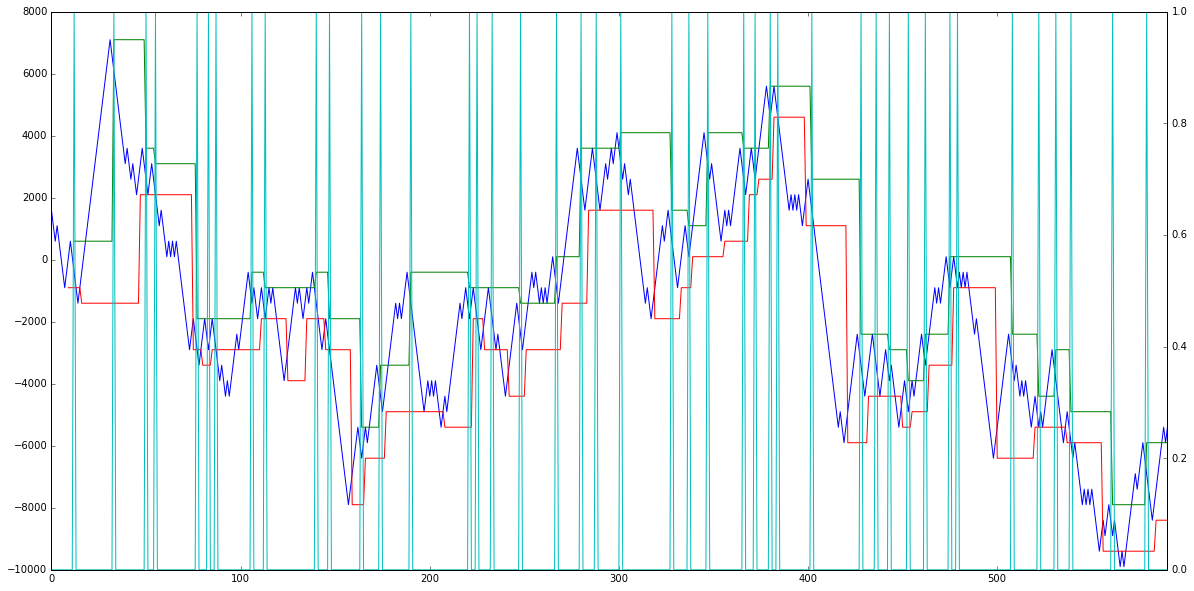

In [421]:
figsize(20,10)
renko_df.close[:].plot()
#renko_df.low[:].plot()

#renko_df.renko_peak_price.plot()


renko_df.renko_peak_price.plot()
renko_df.renko_fall_price.plot()

renko_df.peak.plot(secondary_y=True)